## MNIST Data

Softmax classification based on MNIST data. 

MNIST Data

The following notation is used:
m: Number of samples
n: Number of features

Here the features refer to the pixel values of the images.

For debbuging purposes you may want to choose MNIST light. Set $mnist = 0$ in cell [2]

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds 
from sklearn import model_selection as ms

#get local download folder where data is stored
#you may change this in the call fetch_openml() below
data_h = ds.get_data_home()
print(data_h)

C:\Users\romain.capocasa\scikit_learn_data


In [66]:
#choose 0 to work with mnist light (simpler for debugging) 
mnist = 1

if mnist == 1:
    # the first time this will download the data from the internet and put to a local folder 
    mnist = ds.fetch_openml(name='mnist_784')

    # digit is a "bunch" i.e. similar to a dictionary
    print(type(mnist))
    # show the keys of digit
    print(mnist.keys())
    # get data i.e. the image (x) and labels (y)
    x = mnist['data']
    # as compare to the in class activity we convert the labels here to int
    y = np.array(mnist['target'], dtype='int')
    #set image width
    img_width = 28
else:
    mnist_light = ds.load_digits()
    # digit is a "bunch" i.e. similar to a dictionary
    print(type(mnist_light))
    # show the keys of digit
    print(mnist_light.keys())
    # get data i.e. the image (x) and labels (y)
    x = mnist_light['data']
    y = mnist_light.target
    #set image width
    img_width = 8
    
# get the respective shape
print("x shape:", x.shape)
print("y shape:", y.shape)

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
x shape: (70000, 784)
y shape: (70000,)


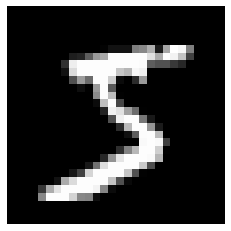

In [67]:
def plot_img(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    
    
img = x[0,:].reshape((img_width,img_width))
plot_img(img)

In [68]:
def plot_tiles(x_array, rows, cols = -1, digit_size = 28, fig_size = [10,10]):
    """
    plot list of mnist images as single image

    Arguments:
    x_array -- array of mnist images (being organised as ROWS!)
    rows/cols -- an image of rows x cols - mnist images is created (if x_array is smaller zeros ared padded)
    digit_size -- width (= height) of one single digit (= 8 for MNIST light, = 28 for MINIST)
    fig_size -- size of full image created (default [10,10])
    """
    #use rows = cols as default
    if cols < 0:
        cols = rows
        
    if x_array.shape[0] < rows*cols:
        cols = int(x_array.shape[0]/rows)
        remain = np.mod(x_array.shape[0], rows)
        if 0 < remain:
            cols += 1
            x_array = np.append(x_array, np.zeros((rows-remain, x_array.shape[1])), 0)    
        
    img = x_array[0:rows,:].reshape(rows*digit_size,digit_size)
    for i0 in range(1,cols):
        #the reshape operator in the append call takes num of digit_size x digit_size images and 
        #puts them in a single column; append then does the rest
        img = np.append(img, x_array[i0*rows:(i0+1)*rows,:].reshape(rows*digit_size,digit_size),1)

    fig = plt.figure(figsize = fig_size)
    ax = fig.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()

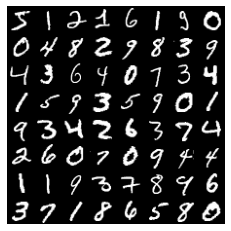

In [69]:
#append rows x cols tiles of digits
rows = 8
cols = 8
#figure size can be set
fig_size = [4,4]

plot_tiles(x, rows, cols, img_width, fig_size)

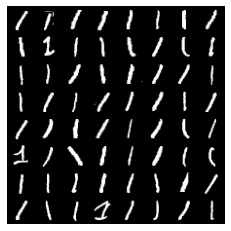

In [70]:
#choose a given digit 0..9
digit  = 1

plot_tiles(x[y == digit,:], rows, cols, img_width, fig_size)

In [71]:
#select training and test set (random_state set the seed for reproducible results)

from sklearn import model_selection as ms

#define train and test split
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, 
                                     test_size=0.20, random_state=1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(56000, 784) (14000, 784) (56000,) (14000,)


In [72]:
class MiniBatches:
    """
    obtains x- and y-data in the constructor and returns a sample of batch_size with each call to next()
    """
    def __init__(self, x, y, batch_size):
        """
        constructor

        Arguments:
        x/y -- data
        batch_size -- size of batch (0 means one single batch)
        """
        self.x = x
        self.y = y
        m = x.shape[0]
        self.indices = np.arange(m)
        self.n = x.shape[1]
        
        if not batch_size:
            self.batch_size = m
            self.mb = 1
        else:
            self.batch_size = batch_size        
            self.mb = int(m / self.batch_size)    
            np.random.shuffle(self.indices)
        
        self.ib = 0

    def number_of_batches(self):
        return self.mb

    def next(self):
        it = self.indices[self.ib * self.batch_size:(self.ib + 1) * self.batch_size]
        x_batch = self.x[it, :]
        y_batch = self.y[it]
        self.ib += 1

        return {'x_batch': x_batch, 'y_batch': y_batch}

### Class GradientDescent

This class summarises the gradient descent steps. The training and test data is given as dictionary (c.f. cell directly below the class definition for an example). The class can be called, however only a dummy implementation is given (weigths w and bias b are always 0). Replace the dummy parts with your own implementation and test it.

In [79]:
class GradientDescent:
    """
    obtains train and test data in the constructor and does the gradient descend
    """

    def __init__(self, data, alpha=0.05, batch_size=256, random_std=0):
        """
        constructor

        Arguments:
        data -- dictionary with data
        alpha -- learning rate
        random_std -- std for initialisation of weight (default is 0)
        """
        # keep local copy of data
        self.data = data
        self.alpha = alpha
        self.batch_size = batch_size
        # number of digits
        self.num_digit = int(max(data['y_train']) + 1)

        # normalize data
        self.normalise_data()

        # initialize weights and bias (zero or random)
        self.initialise_weights(random_std)

        # result array
        self.result_data = np.array([])

        
    def normalise_data(self):
        """
        normalize the input data
        """
        # separate normalisation of train and test data
        self.data['x_train'] /= np.max(self.data['x_train'])
        self.data['x_test'] /= np.max(self.data['x_test'])

        
    def initialise_weights(self, random_std):
        """
        initialise weights
        """
        # initialize weights and bias (if random_std == 0 all weights are zero)
        self.W = random_std * np.random.randn(self.data['x_train'].shape[1], self.num_digit)
        self.B = random_std * np.random.randn(1, self.num_digit)

        
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]

        y_pred_argmax = np.argmax(y_pred, axis=1)
        train_error = np.sum(y != y_pred_argmax) / m

        return train_error

    
    def append_result(self, res_data):
        """
        append cost and error data to output array
        """
        # first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)

        return res_data

    
    def cost_funct(self, y_pred, y):
        """
        calculates the cost function
        """
        m = y.shape[0]
        
        ### START YOUR CODE ###
        
        y_enc = gradD.one_hot(y)
        cross_entropy = - np.sum(y_enc * np.log(y_pred), axis=1)
        
        cost = np.mean(cross_entropy)
        ### END YOUR CODE ###

        return cost

    
    def one_hot(self, y):
        """
        construct onehot vector from set of labels
        """
        m = y.shape[0]
        one_hot = np.zeros((m, self.num_digit), dtype=float)
        
        ### START YOUR CODE ###
        
        #fill in the ones
        one_hot[np.arange(y.size), y] = 1 
        
        ### START YOUR CODE ###    

        return one_hot

    
    def grad_cost(self, y_pred):
        """
        calculates the gradients of cost function wrt w and b
        """
        # abbreviation
        x = self.batch['x_batch']
        y = self.batch['y_batch']
        m = x.shape[0]

        ### START YOUR CODE ###
        
        y_enc = self.one_hot(y)
        grad_W = -(y_enc - y_pred).T @ x / m
        grad_B = - np.mean(y_enc- y_pred, 0)
        
        ### END YOUR CODE ###

        return grad_W.T, grad_B

    
    def predict(self, x):
        """
        implementation of softmax function
        """
        ### START YOUR CODE ###

        z = np.dot(x, gradD.W) + gradD.B
        soft_max = (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T
  
        ### END YOUR CODE ###

        return soft_max

    
    def update(self):
        """
        performs one gradient descend step
        """
        # predicted outcome
        y_pred = self.predict(self.batch['x_batch'])

        grad_W, grad_B = self.grad_cost(y_pred)
        self.W -= self.alpha * grad_W
        self.B -= self.alpha * grad_B
        
    
    def save_results(self, i_step):
        """
        prediction on full data set (train and test) and saving of data
        """
        # predicted outcome for train [0] and test data [1]
        self.y_pred = [self.predict(self.data['x_train']), self.predict(self.data['x_test'])]

        # determine cost functions for train [0] and test data [1]
        self.cost = [self.cost_funct(self.y_pred[0], self.data['y_train']),
                     self.cost_funct(self.y_pred[1], self.data['y_test'])]

        res_data = np.array([[i_step, self.cost[0], self.calc_error(self.y_pred[0], self.data['y_train']),
                              self.cost[1], self.calc_error(self.y_pred[1], self.data['y_test'])]])

        self.append_result(res_data)

        return res_data


        
    def optimise(self, epochs, debug=False):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        debug -- False (default)/True; get info on each gradient descend step
        """
        # save results before step
        res_data = self.save_results(0)

        for i0 in range(0, epochs):
            #create batches for each epoch
            batches = MiniBatches(self.data['x_train'], self.data['y_train'], self.batch_size)

            for ib in range(batches.number_of_batches()):
                self.batch = batches.next()
                self.update()
            
            #we save only once per epoch
            res_data = self.save_results(i0+1)
            if debug and np.mod(i0, 1) == 0:
                print('step %r, cost %r, error %r' % (i0, res_data[0, 1], res_data[0, 2]))

        print('result after %d epochs, train: cost %.5f, error %.5f ; test: cost %.5f, error %.5f'
              % (epochs, res_data[0, 1], res_data[0, 2], res_data[0, 3], res_data[0, 4]))

### Sample execution of gradient descent

The cell below shows how to use the class GradientDescent to perform the optimisation. The training and test data is given as dictionary in the constructor of the class. Then the method optimise is called with first argument being the number of epochs.


In [74]:
#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_train, 'y_train' : y_train, 'x_test' : x_test, 'y_test' : y_test}

alpha=0.1
batch_size=256

gradD = GradientDescent(data, alpha, batch_size, 0.)

gradD.optimise(100, False)

result after 100 epochs, train: cost 0.24835, error 0.06838 ; test: cost 0.28806, error 0.07929


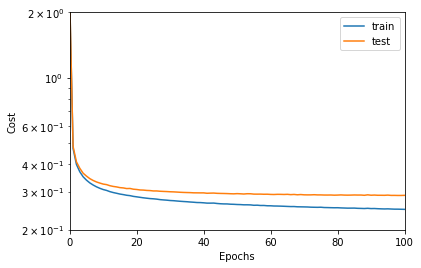

In [75]:
#analyse cost as function of epochs
epochs = gradD.result_data[:,0]
train_costs = gradD.result_data[:,1]
test_costs = gradD.result_data[:,3]

plt.semilogy(epochs, train_costs, label="train")
plt.semilogy(epochs, test_costs, label="test")
plt.ylabel('Cost')
plt.xlabel('Epochs')
xmax = epochs[-1]
ymin = 2e-1
ymax = 2
plt.axis([0,xmax,ymin,ymax])
plt.legend()
plt.show() 

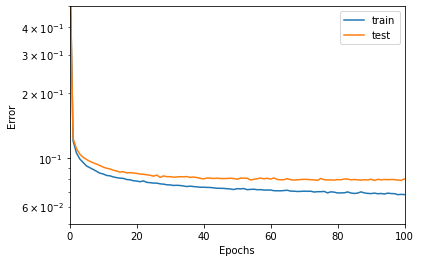

In [64]:
#analyse error as function of epochs
epochs = gradD.result_data[:,0]
train_error = gradD.result_data[:,2]
test_error = gradD.result_data[:,4]

plt.semilogy(epochs, train_error, label="train")
plt.semilogy(epochs, test_error, label="test")
plt.ylabel('Error')
plt.xlabel('Epochs')
xmax = epochs[-1]
ymin = 5e-2
ymax = 5e-1
plt.axis([0,xmax,ymin,ymax])
plt.legend()
plt.show() 

### Describe your Findings for Exercise 1b

By running the training with different settings for learning rate, number of epochs, batch size explore which combination is best suited to obtain good test performance. Keep an eye on random estimates for the error rates due to random parameter initialisation and randomly shuffled mini-batches.

Specify your choice of these hyper-parameters and justify why you consider your choice best suited.


#### YOUR FINDINGS ...

The higher the learning rate, the more the curve oscillates as opposed to the curve with a low learning rate.

We can see that the model converges with few epochs, 50 epochs are enough to make the model converge. 

From about 20 epochs the cost and error of the test set does not go down anymore.

Batch size does not seem to show a significant influence on the cost and error of the model

(1128, 784)
[[8 0 9 5 3 3 1 7 8 8]
 [7 5 7 1 5 5 9 0 8 9]
 [7 2 7 9 2 8 4 4 7 7]
 [9 9 5 2 7 3 3 8 9 5]
 [7 5 6 7 0 7 4 8 9 9]
 [3 8 6 7 9 2 5 8 4 3]
 [9 4 3 8 5 5 3 4 8 2]
 [0 8 5 5 4 2 5 5 2 2]
 [7 7 8 9 2 4 5 5 6 7]
 [3 7 5 2 2 8 6 8 9 3]]


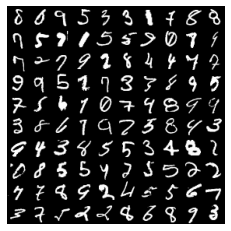

In [13]:
#analyse false classified training or test images

#switch to see training errors
#y_pred = gradD.y_pred[0]
#x_data = x_train
#y_data = y_train
y_pred = gradD.y_pred[1]
x_data = x_test
y_data = y_test


#choose here the number of digits shown, a full image of rows x cols tiles of digits is created
rows = 10
cols = 10
#figure size can be set
fig_size = [4,4]


yhat = np.argmax(y_pred, axis=1)
indices = np.where(yhat != y_data)[0]

false_classifications = x_data[indices,:]

print(false_classifications.shape)

plot_tiles(false_classifications, rows, cols, img_width, fig_size)


#print the correct labels 
correct_labels = y_data[indices]

if correct_labels.shape[0] < rows*cols:
    correct_labels = np.append(correct_labels, -np.ones((rows*cols-correct_labels.shape[0])))
    
correct_labels = correct_labels[:rows*cols].reshape(cols,rows).T

print(np.array(correct_labels, dtype = int))

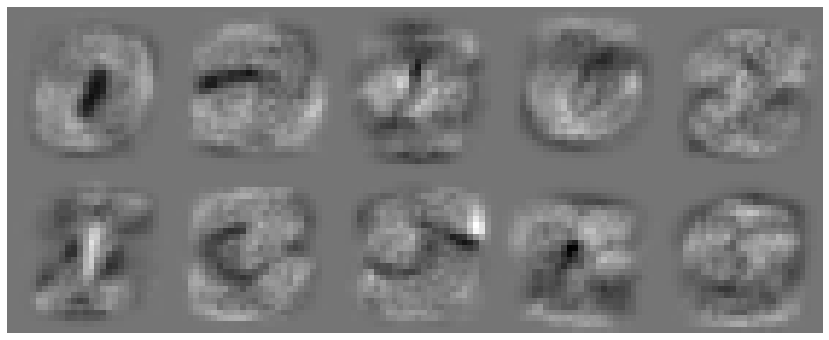

In [14]:
#visualise the weights, order is:
#0 2 4 6 8
#1 3 5 7 9 

rows = 2
cols = 5
#figure size can be set
fig_size = [15,6]

plot_tiles(gradD.W.T, rows, cols, img_width, fig_size)

# Unit Tests
### Unit Test for predict¶


In [15]:
#create dummy instance
hx = np.ones((2,2))
hy = np.ones((2,1))
data = {'x_train' : hx, 'y_train' : hy, 'x_test' : hx, 'y_test' : hy}
gradD = GradientDescent(data, 0.5, 20, 0.)

gradD.W = np.array([[ 1,  0, -1],[-1,  1,  1]]).reshape(2,3)
gradD.B = np.array([0,0,0]).reshape(1,3)
x = np.array([2, 3]).reshape(1,2)
y_pred = gradD.predict(x)
y_exp = np.array([0.01587624,0.86681333,0.11731043]).reshape(y_pred.shape)

np.testing.assert_array_almost_equal(y_pred,y_exp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(y_pred, axis=1), 1.0, decimal=8)

x = np.array([[ 2,  1],[-1,  1],[ 1,  1],[-1,  1]]).reshape(4,2)
y_pred = gradD.predict(x)
y_exp = np.array([[0.46831053, 0.46831053, 0.06337894],
       [0.01321289, 0.26538793, 0.72139918],
       [0.21194156, 0.57611688, 0.21194156],
       [0.01321289, 0.26538793, 0.72139918]]
)
np.testing.assert_array_almost_equal(y_pred,y_exp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(y_pred, axis=1), np.ones(4,dtype='float'), decimal=8)

### Unit Test for cost_function

In [16]:
#create dummy instance
hx = np.ones((2,2))
hy = np.ones((2,1))
data = {'x_train' : hx, 'y_train' : hy, 'x_test' : hx, 'y_test' : hy}
gradD = GradientDescent(data, 0.5, 20, 0.)

y = np.array([1])
y_pred = np.array([0.04742587,0.95257413]).reshape(1,2)
cost = gradD.cost_funct(y_pred, y)
cost_exp = 0.04858735
np.testing.assert_almost_equal(cost,cost_exp,decimal=8)

y = np.array([1,1,1,0])
y_pred = np.array([[1.79862100e-02, 6.69285092e-03, 4.74258732e-02, 9.99088949e-01],
                  [9.82013790e-01, 9.93307149e-01, 9.52574127e-01, 9.11051194e-04]]).T
cost = gradD.cost_funct(y_pred, y)
cost_exp = 0.01859102
np.testing.assert_almost_equal(cost,cost_exp,decimal=8)

### Unit Test for one_hot

In [17]:
#create dummy instance
hx = np.ones((2,2))
hy = np.ones((2,1))
data = {'x_train' : hx, 'y_train' : hy, 'x_test' : hx, 'y_test' : hy}
gradD = GradientDescent(data, 0.5, 20, 0.)

y = np.array([1,3,0])
gradD.num_digit = 4
one_hot = gradD.one_hot(y)
one_hot_exp = np.array([[0,1,0,0],
                        [0,0,0,1],
                        [1,0,0,0]])
np.testing.assert_almost_equal(one_hot,one_hot_exp,decimal=8)

### Unit Test for grad_cost
Assumes that Unit Test for predict is correct!

In [18]:
#create dummy instance
hx = np.ones((2,2))
hy = np.ones((2,1))
data = {'x_train' : hx, 'y_train' : hy, 'x_test' : hx, 'y_test' : hy}
gradD = GradientDescent(data, 0.5, 20, 0.)

gradD.W = np.array([[ 1,  0, -1],[-1,  1,  1]]).reshape(2,3)
gradD.B = np.array([0,0,0]).reshape(1,3)
x = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4).T
y = np.array([1,1,1,1])
y_pred = gradD.predict(x)
gradD.num_digit = 3

gradD.batch = {'x_batch': x, 'y_batch': y}

grad_W, grad_B = gradD.grad_cost(y_pred)

grad_W_exp = np.array([[ 0.28053421, -0.00450948, -0.27602473],
                       [ 0.17666947, -0.60619918,  0.42952972]])
grad_B_exp = np.array([0.17666947,-0.60619918,0.42952972])
np.testing.assert_array_almost_equal(grad_W,grad_W_exp,decimal=8)
np.testing.assert_array_almost_equal(grad_B,grad_B_exp, decimal=8)